# MLP
MLP, K=5, droput, 150 epoch.

mRNA. Exclude train middle.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 15:11:34.087070


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = True
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_248'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.csv'
RCI_FILE_TEST  = None #'test.pc_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_pc_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 15:12:06.132414
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = 0 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = 0   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold) # lncRNA
        filename='pc.{}.{}.validation_genes.txt'.format(rep,fold) # mRNA
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            # use -2 and 0 for lncRNA, use -1 and +1 for mRNA
            in_middle = gene_to_rci[gene_id] >= -1 and gene_to_rci[gene_id] <= 1
            in_tails = gene_to_rci[gene_id] < -1 or gene_to_rci[gene_id] > 1
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 15:12:06.945892
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.csv
Number of RCI values loaded 13662
Num RCI: 13662
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_pc_transcripts.csv
Loaded 13662 sequences.

Training # 1 1
2023-04-09 15:13:06.990560
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.1.validation_genes.txt
2023-04-09 15:13:07.435335
Discriminator ZERO 0
Train 1:0 1948:2780 41.20%
Valid 1:0 1257:1476 45.99%
FIT
2023-04-09 15:13:07.549798


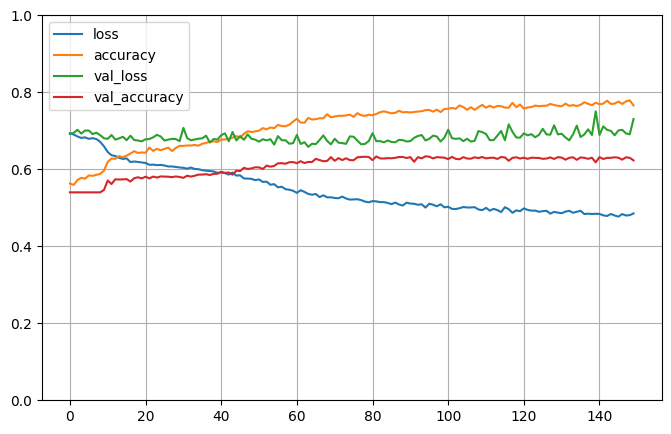


Testing # 1 1
2023-04-09 15:15:19.639995
2023-04-09 15:15:19.640053
PREDICT
2023-04-09 15:15:19.666516
Test 1:0 1257:1476 45.99%
Predict 1:0 713:2020 26.09%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.3371823 mean 0.24840727 std
Range of scores: 0.010694545 to 0.99478555
Score threshold 0.5
Confusion matrix
 [[1233  243]
 [ 787  470]]
Normalized matrix
 [[0.45115258 0.08891328]
 [0.28796195 0.17197219]]
Extreme scores correct, pos:neg 286 1046
Extreme scores incorrect pos:neg 111 582


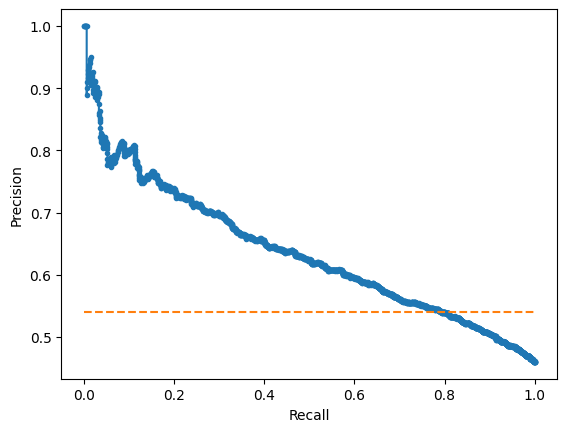

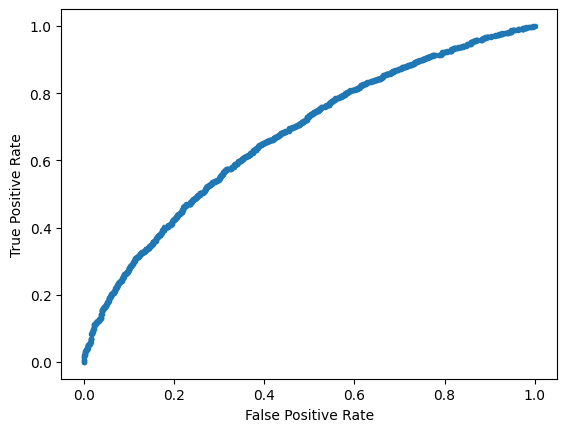

Accuracy: 62.31% Precision: 65.92% Recall: 37.39%
F1: 47.72% MCC: 0.2375
AUPRC: 63.67% AUROC: 67.40%
 accuracy [62.31247713135748]
 precision [65.91865357643759]
 recall [37.390612569610184]
 F1 [47.71573604060914]
 MCC [0.23752069203935208]
 AUPRC [63.672974730183284]
 AUROC [67.39947351740821]

Training # 1 2
2023-04-09 15:15:20.450092
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.2.validation_genes.txt
2023-04-09 15:15:20.844667
Discriminator ZERO 0
Train 1:0 1891:2822 40.12%
Valid 1:0 1316:1417 48.15%
FIT
2023-04-09 15:15:20.948705


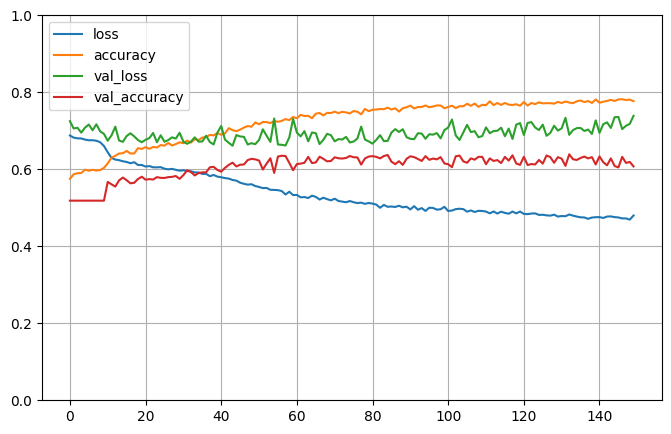


Testing # 1 2
2023-04-09 15:17:30.805704
2023-04-09 15:17:30.805752
PREDICT
2023-04-09 15:17:30.833916
Test 1:0 1316:1417 48.15%
Predict 1:0 689:2044 25.21%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.3394866 mean 0.24861 std
Range of scores: 0.013768577 to 0.996269
Score threshold 0.5
Confusion matrix
 [[1194  223]
 [ 850  466]]
Normalized matrix
 [[0.43688255 0.08159532]
 [0.31101354 0.1705086 ]]
Extreme scores correct, pos:neg 287 1015
Extreme scores incorrect pos:neg 100 603


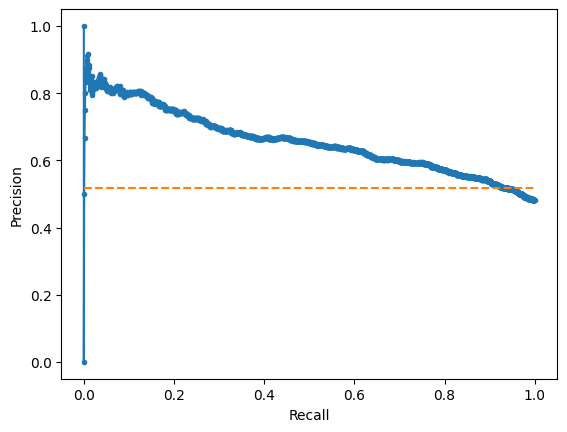

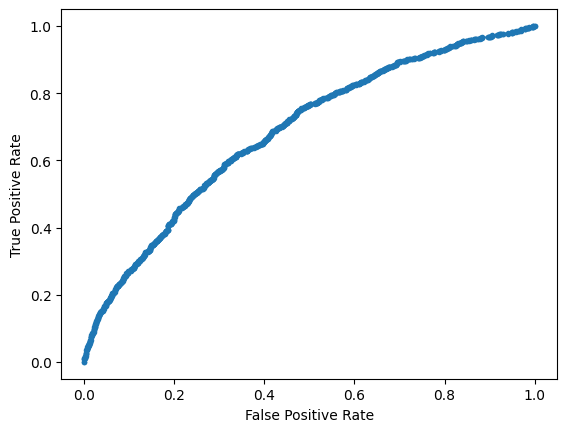

Accuracy: 60.74% Precision: 67.63% Recall: 35.41%
F1: 46.48% MCC: 0.2264
AUPRC: 65.58% AUROC: 68.37%
 accuracy [60.73911452616173]
 precision [67.63425253991292]
 recall [35.410334346504555]
 F1 [46.48379052369078]
 MCC [0.226375974216812]
 AUPRC [65.58188597613858]
 AUROC [68.37369394220848]

Training # 1 3
2023-04-09 15:17:31.539346
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.3.validation_genes.txt
2023-04-09 15:17:31.997759
Discriminator ZERO 0
Train 1:0 1924:2782 40.88%
Valid 1:0 1288:1444 47.14%
FIT
2023-04-09 15:17:32.099728


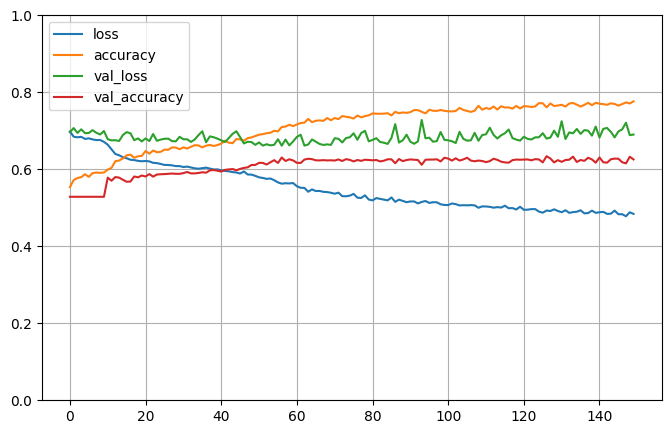


Testing # 1 3
2023-04-09 15:19:41.692534
2023-04-09 15:19:41.692584
PREDICT
2023-04-09 15:19:41.714621
Test 1:0 1288:1444 47.14%
Predict 1:0 1071:1661 39.20%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.4291885 mean 0.2636457 std
Range of scores: 0.020984234 to 0.99627924
Score threshold 0.5
Confusion matrix
 [[1041  403]
 [ 620  668]]
Normalized matrix
 [[0.38103953 0.14751098]
 [0.22693997 0.24450952]]
Extreme scores correct, pos:neg 450 818
Extreme scores incorrect pos:neg 208 405


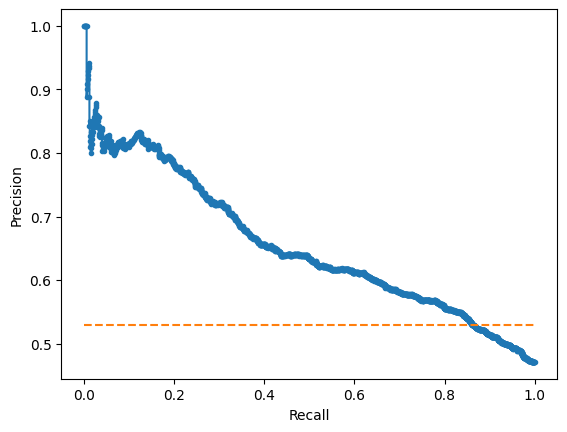

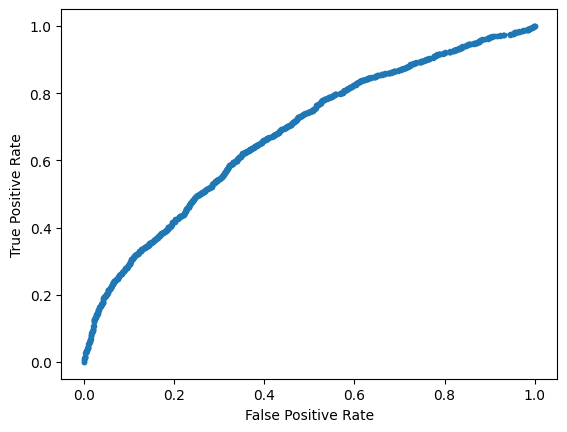

Accuracy: 62.55% Precision: 62.37% Recall: 51.86%
F1: 56.63% MCC: 0.2449
AUPRC: 65.44% AUROC: 67.89%
 accuracy [62.55490483162518]
 precision [62.37161531279178]
 recall [51.86335403726709]
 F1 [56.634167019923694]
 MCC [0.24493673446881237]
 AUPRC [65.4375996891796]
 AUROC [67.88867728531855]

Training # 1 4
2023-04-09 15:19:42.594911
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.4.validation_genes.txt
2023-04-09 15:19:42.923895
Discriminator ZERO 0
Train 1:0 1939:2779 41.10%
Valid 1:0 1259:1473 46.08%
FIT
2023-04-09 15:19:43.026114


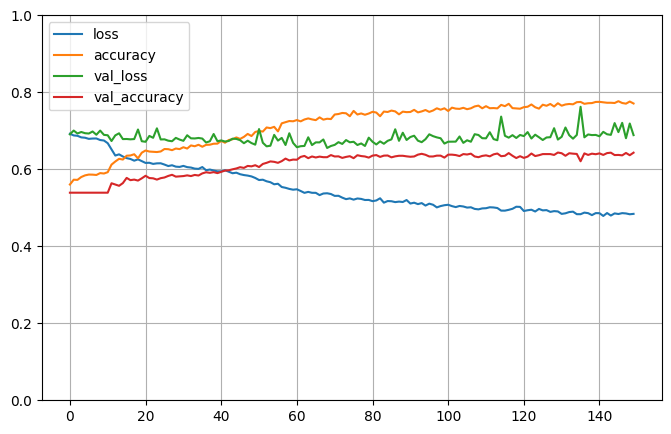


Testing # 1 4
2023-04-09 15:22:06.264393
2023-04-09 15:22:06.266406
PREDICT
2023-04-09 15:22:06.291456
Test 1:0 1259:1473 46.08%
Predict 1:0 1094:1638 40.04%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.43175748 mean 0.27390876 std
Range of scores: 0.012196632 to 0.991835
Score threshold 0.5
Confusion matrix
 [[1068  405]
 [ 570  689]]
Normalized matrix
 [[0.3909224  0.14824305]
 [0.20863836 0.25219619]]
Extreme scores correct, pos:neg 490 839
Extreme scores incorrect pos:neg 221 400


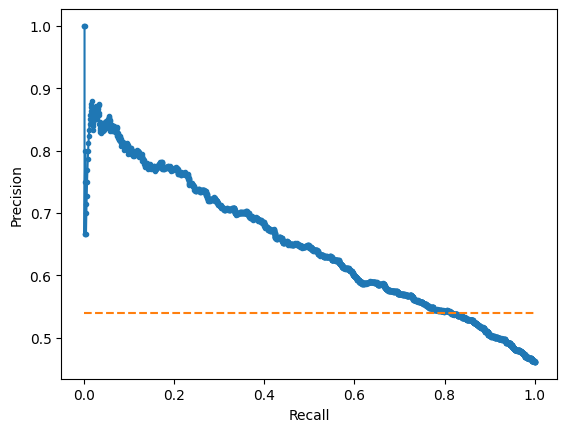

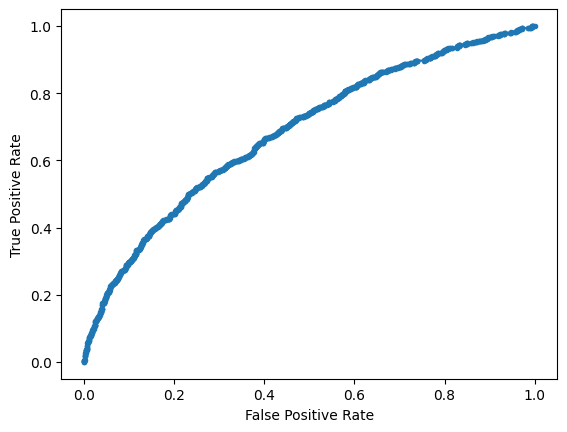

Accuracy: 64.31% Precision: 62.98% Recall: 54.73%
F1: 58.56% MCC: 0.2770
AUPRC: 64.86% AUROC: 68.39%
 accuracy [64.31185944363104]
 precision [62.979890310786104]
 recall [54.72597299444003]
 F1 [58.5635359116022]
 MCC [0.2770213554427623]
 AUPRC [64.86075277677615]
 AUROC [68.39022446396805]

Training # 1 5
2023-04-09 15:22:07.055973
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.5.validation_genes.txt
2023-04-09 15:22:07.789521
Discriminator ZERO 0
Train 1:0 1906:2789 40.60%
Valid 1:0 1320:1412 48.32%
FIT
2023-04-09 15:22:07.915339


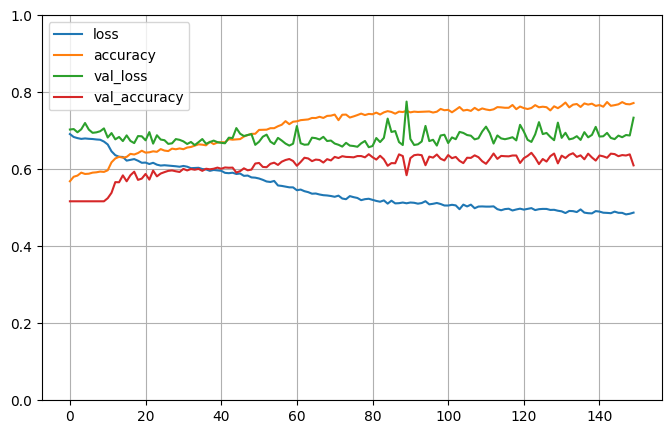


Testing # 1 5
2023-04-09 15:24:16.956608
2023-04-09 15:24:16.957002
PREDICT
2023-04-09 15:24:16.979705
Test 1:0 1320:1412 48.32%
Predict 1:0 627:2105 22.95%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.32442537 mean 0.22921875 std
Range of scores: 0.015247139 to 0.99478555
Score threshold 0.5
Confusion matrix
 [[1226  186]
 [ 879  441]]
Normalized matrix
 [[0.44875549 0.06808199]
 [0.32174231 0.1614202 ]]
Extreme scores correct, pos:neg 226 1056
Extreme scores incorrect pos:neg 66 631


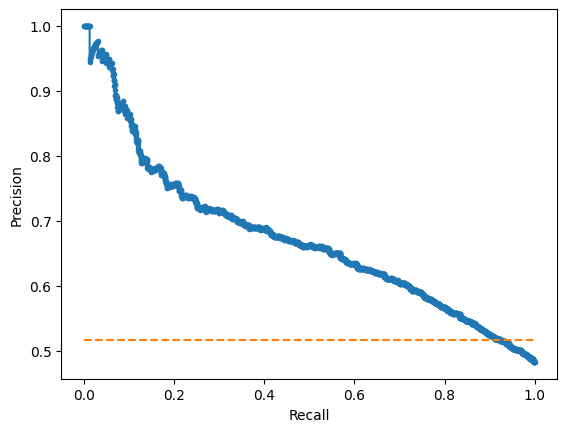

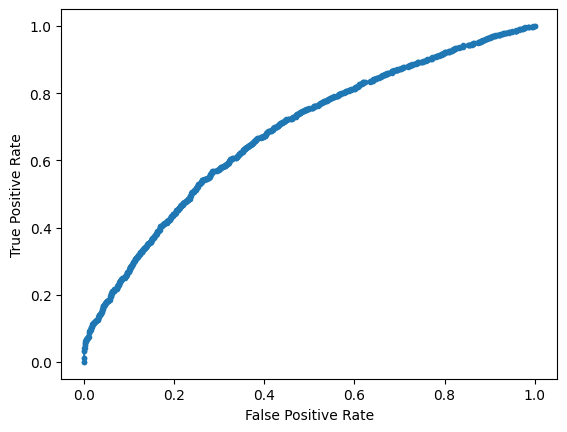

Accuracy: 61.02% Precision: 70.33% Recall: 33.41%
F1: 45.30% MCC: 0.2405
AUPRC: 67.33% AUROC: 68.42%
 accuracy [61.01756954612006]
 precision [70.33492822966507]
 recall [33.409090909090914]
 F1 [45.300462249614796]
 MCC [0.24047797723384345]
 AUPRC [67.32958547165349]
 AUROC [68.42132371877415]

Training # 2 1
2023-04-09 15:24:17.986891
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.1.validation_genes.txt
2023-04-09 15:24:18.378696
Discriminator ZERO 0
Train 1:0 1924:2804 40.69%
Valid 1:0 1297:1436 47.46%
FIT
2023-04-09 15:24:18.538083


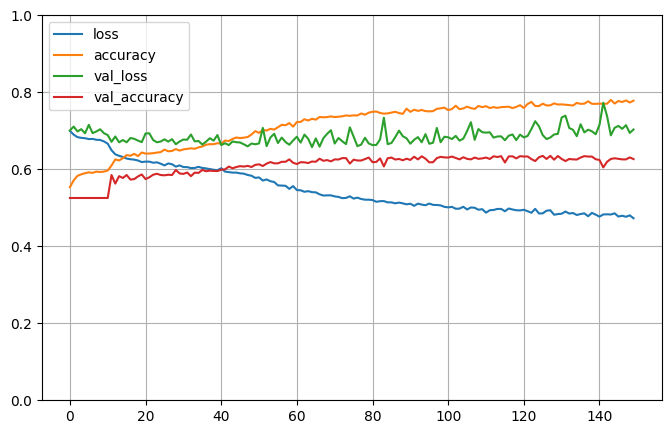


Testing # 2 1
2023-04-09 15:26:27.021050
2023-04-09 15:26:27.021103
PREDICT
2023-04-09 15:26:27.045341
Test 1:0 1297:1436 47.46%
Predict 1:0 828:1905 30.30%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.37761346 mean 0.2503296 std
Range of scores: 0.020927135 to 0.9982324
Score threshold 0.5
Confusion matrix
 [[1160  276]
 [ 745  552]]
Normalized matrix
 [[0.42444201 0.10098793]
 [0.27259422 0.20197585]]
Extreme scores correct, pos:neg 348 927
Extreme scores incorrect pos:neg 126 521


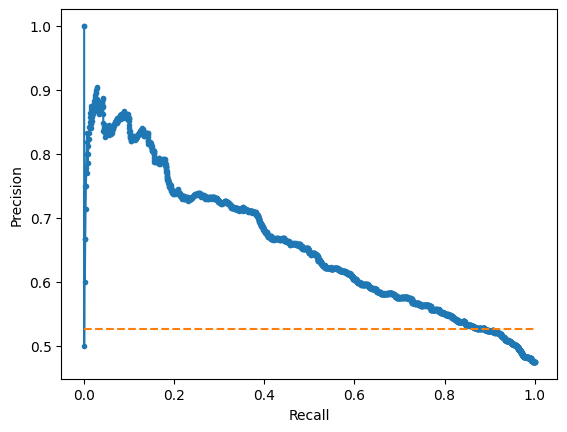

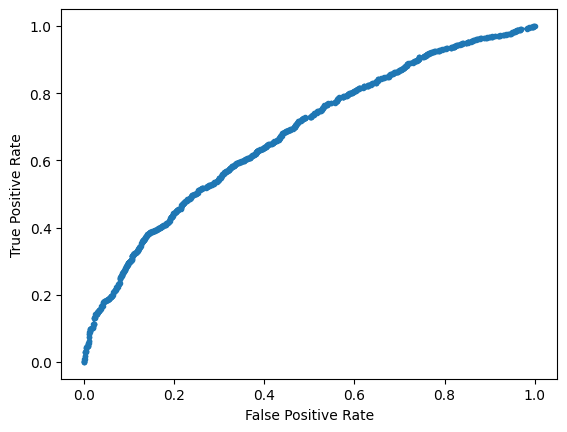

Accuracy: 62.64% Precision: 66.67% Recall: 42.56%
F1: 51.95% MCC: 0.2536
AUPRC: 65.70% AUROC: 67.76%
 accuracy [62.641785583607756]
 precision [66.66666666666666]
 recall [42.5597532767926]
 F1 [51.95294117647059]
 MCC [0.2536178250192238]
 AUPRC [65.697603690705]
 AUROC [67.759673598598]

Training # 2 2
2023-04-09 15:26:27.763440
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.2.validation_genes.txt
2023-04-09 15:26:28.550033
Discriminator ZERO 0
Train 1:0 1930:2769 41.07%
Valid 1:0 1264:1469 46.25%
FIT
2023-04-09 15:26:28.656949


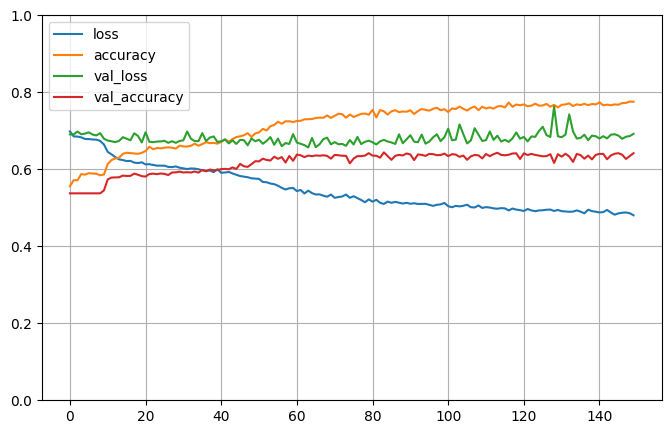


Testing # 2 2
2023-04-09 15:28:36.690836
2023-04-09 15:28:36.690885
PREDICT
2023-04-09 15:28:36.714381
Test 1:0 1264:1469 46.25%
Predict 1:0 1099:1634 40.21%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.42890733 mean 0.2715811 std
Range of scores: 0.012530405 to 0.99392194
Score threshold 0.5
Confusion matrix
 [[1062  407]
 [ 572  692]]
Normalized matrix
 [[0.38858397 0.1489206 ]
 [0.20929382 0.25320161]]
Extreme scores correct, pos:neg 465 814
Extreme scores incorrect pos:neg 211 389


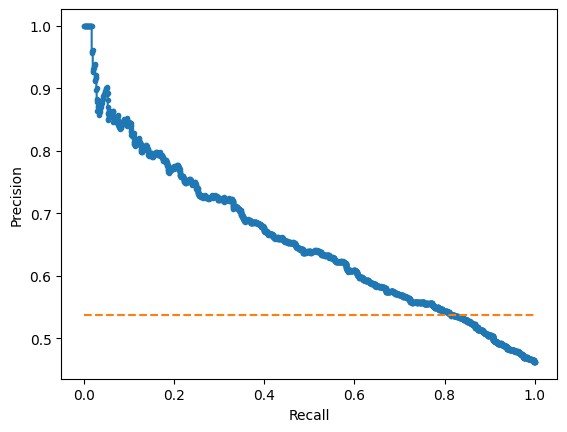

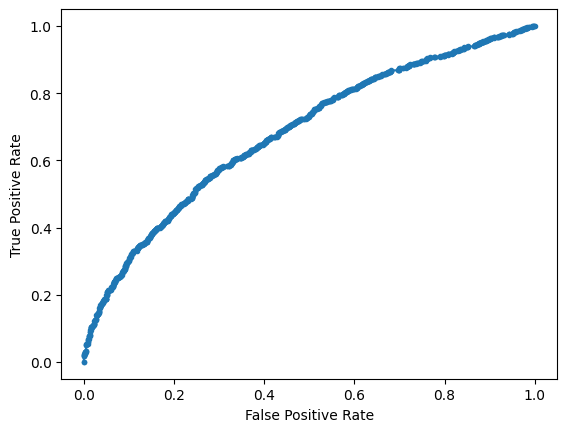

Accuracy: 64.18% Precision: 62.97% Recall: 54.75%
F1: 58.57% MCC: 0.2750
AUPRC: 65.67% AUROC: 68.16%
 accuracy [64.17855836077571]
 precision [62.9663330300273]
 recall [54.74683544303798]
 F1 [58.56961489631824]
 MCC [0.2749672145257113]
 AUPRC [65.67243878675588]
 AUROC [68.15608008547966]

Training # 2 3
2023-04-09 15:28:38.047637
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.3.validation_genes.txt
2023-04-09 15:28:38.569385
Discriminator ZERO 0
Train 1:0 1931:2831 40.55%
Valid 1:0 1305:1428 47.75%
FIT
2023-04-09 15:28:38.694651


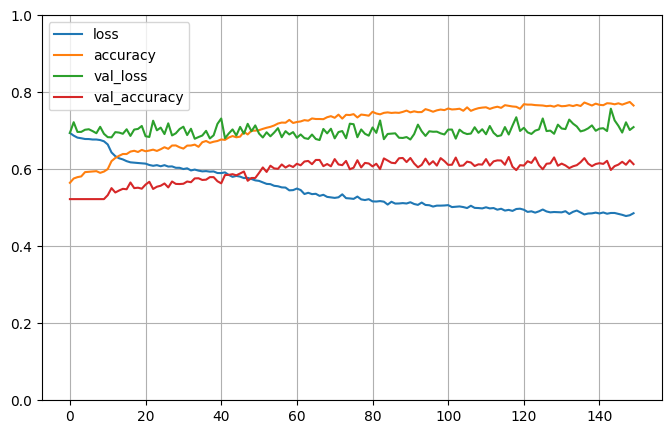


Testing # 2 3
2023-04-09 15:30:52.404779
2023-04-09 15:30:52.404834
PREDICT
2023-04-09 15:30:52.428258
Test 1:0 1305:1428 47.75%
Predict 1:0 964:1769 35.27%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.40576833 mean 0.26106292 std
Range of scores: 0.013403716 to 0.9961502
Score threshold 0.5
Confusion matrix
 [[1070  358]
 [ 699  606]]
Normalized matrix
 [[0.39151116 0.13099158]
 [0.2557629  0.22173436]]
Extreme scores correct, pos:neg 395 870
Extreme scores incorrect pos:neg 184 449


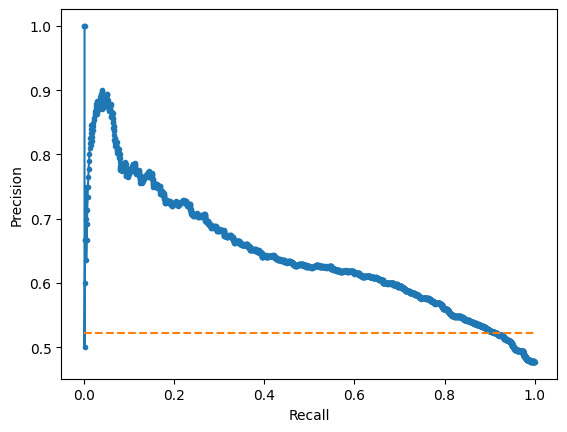

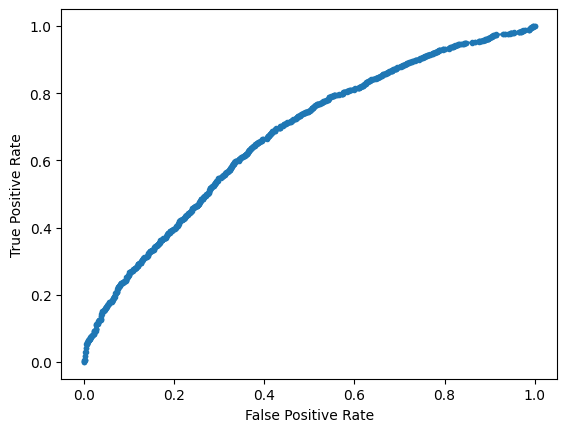

Accuracy: 61.32% Precision: 62.86% Recall: 46.44%
F1: 53.42% MCC: 0.2234
AUPRC: 64.36% AUROC: 67.36%
 accuracy [61.32455177460666]
 precision [62.863070539419084]
 recall [46.43678160919541]
 F1 [53.41560158660204]
 MCC [0.22336003443362462]
 AUPRC [64.36160512528456]
 AUROC [67.3561071938354]

Training # 2 4
2023-04-09 15:30:53.301209
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.4.validation_genes.txt
2023-04-09 15:30:53.819053
Discriminator ZERO 0
Train 1:0 1890:2771 40.55%
Valid 1:0 1314:1418 48.10%
FIT
2023-04-09 15:30:53.944758


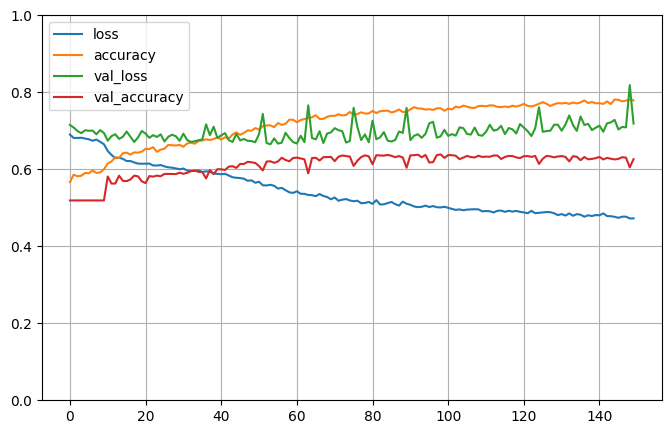


Testing # 2 4
2023-04-09 15:33:17.187541
2023-04-09 15:33:17.187975
PREDICT
2023-04-09 15:33:17.219555
Test 1:0 1314:1418 48.10%
Predict 1:0 1479:1253 54.14%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.5236108 mean 0.28732517 std
Range of scores: 0.01567137 to 0.9972315
Score threshold 0.5
Confusion matrix
 [[825 593]
 [428 886]]
Normalized matrix
 [[0.30197657 0.2170571 ]
 [0.15666179 0.32430454]]
Extreme scores correct, pos:neg 686 620
Extreme scores incorrect pos:neg 381 302


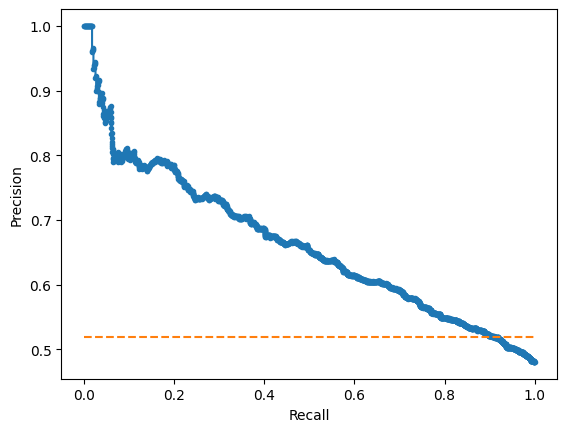

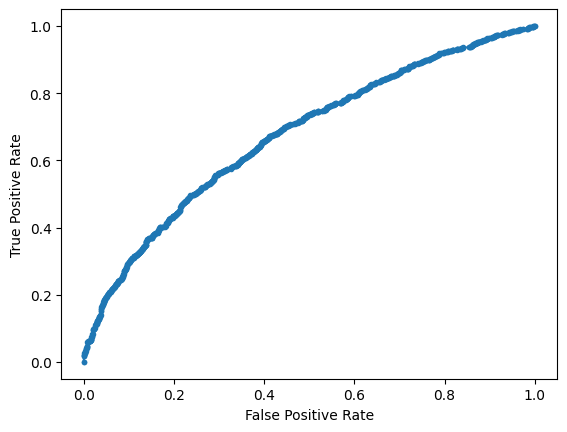

Accuracy: 62.63% Precision: 59.91% Recall: 67.43%
F1: 63.44% MCC: 0.2568
AUPRC: 66.25% AUROC: 67.51%
 accuracy [62.6281112737921]
 precision [59.9053414469236]
 recall [67.42770167427702]
 F1 [63.44432509846043]
 MCC [0.25677685000910466]
 AUPRC [66.24628298074734]
 AUROC [67.50608613327667]

Training # 2 5
2023-04-09 15:33:18.123520
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.5.validation_genes.txt
2023-04-09 15:33:18.489135
Discriminator ZERO 0
Train 1:0 1933:2777 41.04%
Valid 1:0 1260:1471 46.14%
FIT
2023-04-09 15:33:18.608376


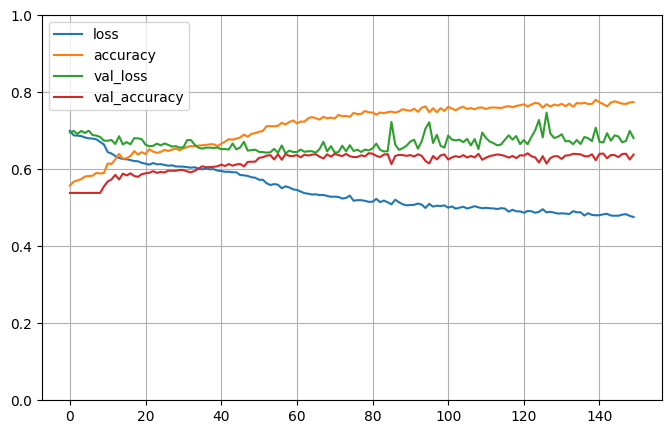


Testing # 2 5
2023-04-09 15:35:42.032049
2023-04-09 15:35:42.032114
PREDICT
2023-04-09 15:35:42.057477
Test 1:0 1260:1471 46.14%
Predict 1:0 1028:1703 37.64%
Test sizes (2731, 1025) (2731,)
Distrib of scores: 0.4175692 mean 0.27063 std
Range of scores: 0.00860235 to 0.99166155
Score threshold 0.5
Confusion matrix
 [[1093  378]
 [ 610  650]]
Normalized matrix
 [[0.4002197  0.13841084]
 [0.22336141 0.23800806]]
Extreme scores correct, pos:neg 445 880
Extreme scores incorrect pos:neg 212 400


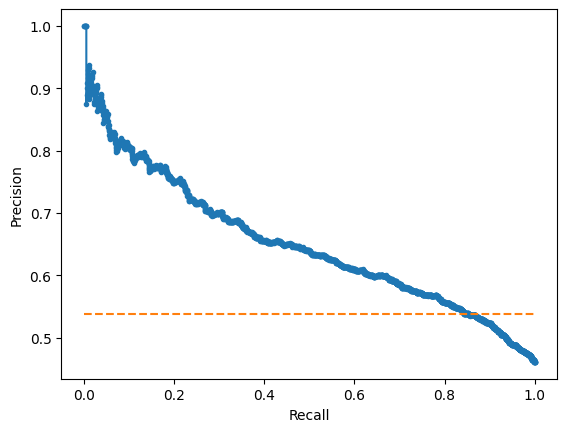

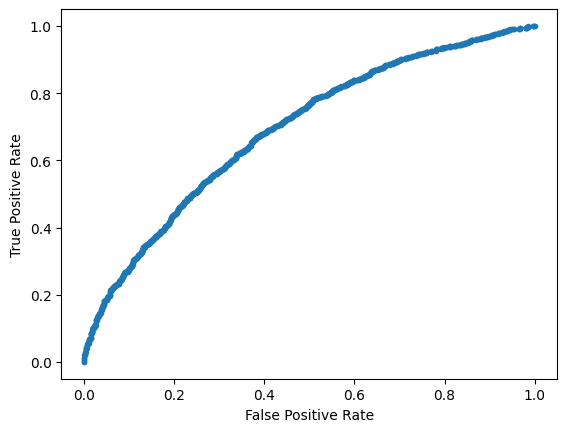

Accuracy: 63.82% Precision: 63.23% Recall: 51.59%
F1: 56.82% MCC: 0.2664
AUPRC: 65.12% AUROC: 69.14%
 accuracy [63.8227755400952]
 precision [63.22957198443579]
 recall [51.587301587301596]
 F1 [56.81818181818182]
 MCC [0.26639625166442926]
 AUPRC [65.11958461665812]
 AUROC [69.13534686478262]
2023-04-09 15:35:42.817767


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 62.55% std 1.27
 precision mean 64.49% std 3.08
 recall mean 47.56% std 10.59
 F1 mean 53.89% std 5.98
 MCC mean 0.2501 std 0.0189
 AUPRC mean 65.40% std 1.00
 AUROC mean 68.04% std 0.56
 accuracy [[62.31247713135748], [60.73911452616173], [62.55490483162518], [64.31185944363104], [61.01756954612006], [62.641785583607756], [64.17855836077571], [61.32455177460666], [62.6281112737921], [63.8227755400952]]
 precision [[65.91865357643759], [67.63425253991292], [62.37161531279178], [62.979890310786104], [70.33492822966507], [66.66666666666666], [62.9663330300273], [62.863070539419084], [59.9053414469236], [63.22957198443579]]
 recall [[37.390612569610184], [35.410334346504555], [51.86335403726709], [54.72597299444003], [33.409090909090914], [42.5597532767926], [54.74683544303798], [46.43678160919541], [67.42770167427702], [51.587301587301596]]
 F1 [[47.71573604060914], [46.48379052369078], [56.634167019923694], [58.5635359116022], [45.300462249614796], [51.95294117647059], [5